In [62]:
import pandas as pd
import numpy as np
from geopy.distance import distance as geo_dist
import datetime
import time
import matplotlib.pyplot as plt
import scipy.stats as st
import os

Below, we extract the stations from the metadata file and compute their distance to Zürich HB. 
Each data files are then filtered and only contain station at a distance lower than 10 km to Zürich HB.

In [2]:
# Extract list of stop from metadata file.
with open("data/BFKOORD_GEO") as file:
    metadata = file.readlines()
    
metadata_cleaned = [line.split("%") for line in metadata]
metadata_cleaned = [[line[0].split(), line[1][1:-1]] for line in  metadata_cleaned]
metadata_cleaned = [[line[0][0], line[0][1], line[0][2], line[0][3], line[1]] for line in metadata_cleaned]

metadata_df = pd.DataFrame(metadata_cleaned, columns=["StationID", "Longitude", "Latitude", "Height", "Remark"])

metadata_df["Longitude"] = pd.to_numeric(metadata_df["Longitude"])
metadata_df["Latitude"] = pd.to_numeric(metadata_df["Latitude"])

In [3]:
# Retrieve stops near Zurich main station
zurichHB = metadata_df[metadata_df.Remark == "Zürich HB"]

metadata_df["dist"] = metadata_df.apply(lambda x: geo_dist((zurichHB.Latitude.values[0], zurichHB.Longitude.values[0]),
                                                            (x.Latitude, x.Longitude)).km, axis=1)
zurich_stops_df = metadata_df[metadata_df["dist"] < 10]
zurich_stops_df.head()

,StationID,Longitude,Latitude,Height,Remark,dist
74,0000176,8.521961,47.351679,0,Zimmerberg-Basistunnel,3.251969
2084,8502220,8.434713,47.390882,442,Urdorf,8.088858
2085,8502221,8.437543,47.357432,488,Birmensdorf ZH,8.089105
2086,8502222,8.468175,47.325896,528,Bonstetten-Wettswil,7.961914
2092,8502229,8.430330,47.380971,456,Urdorf Weihermatt,8.302117


In [ ]:
zurich_stops_lower_name = zurich_stops_df.Remark.str.lower()
for d in os.listdir("data/raw"):
    for f in os.listdir(os.path.join("data/raw", d)):
        print(f, end="\r")
        data_df = pd.read_csv(os.path.join("data/raw", os.path.join(d, f)), sep=";").dropna(subset = ["HALTESTELLEN_NAME"])
        filtered_data = data_df[data_df.HALTESTELLEN_NAME.str.lower().isin(zurich_stops_lower_name)]    
        filtered_data.to_csv(os.path.join("data/filtered", os.path.join(d, f)), sep=";", index=False)

________________________________________________________

In [5]:
original_df = pd.read_csv("data/filtered/2017-09/2017-09-25istdaten.csv", sep=";")

/home/student/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
directory = "data/filtered/2017-09"
all_files = os.listdir(directory)
month_df = pd.concat((pd.read_csv(os.path.join(directory, f), sep=";") for f in all_files))

/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
def to_timestamp(x, date_format):
    if pd.isnull(x):
        return x
    else:
        return time.mktime(datetime.datetime.strptime(x, date_format).timetuple())

def to_time_bucket(x):
    if pd.isnull(x):
        return x
    date = datetime.datetime.fromtimestamp(x)
    return 2*date.hour + int(date.minute > 30)
    
def compute_and_add_delay(df):
    df["AN_PROGNOSE_TS"] = df["AN_PROGNOSE"].apply(lambda x : to_timestamp(x, "%d.%m.%Y %H:%M:%S"))
    df["ANKUNFTSZEIT_TS"] = df["ANKUNFTSZEIT"].apply(lambda x : to_timestamp(x, "%d.%m.%Y %H:%M"))
    df["AB_PROGNOSE_TS"] = df["AB_PROGNOSE"].apply(lambda x : to_timestamp(x, "%d.%m.%Y %H:%M:%S"))
    df["ABFAHRTSZEIT_TS"] = df["ABFAHRTSZEIT"].apply(lambda x : to_timestamp(x, "%d.%m.%Y %H:%M"))
    df["DAY_OF_WEEK"] = df["BETRIEBSTAG"].apply(lambda x : datetime.datetime.strptime(x, "%d.%m.%Y").weekday())
    
    ## TODO remove entries where AN_PROGNOSE_TS and AB_PROGNOSE_TS are nan
    df["TIME_BUCKET"] = df["AN_PROGNOSE_TS"].apply(to_time_bucket)
    

    AN_DELAY = np.round((df["AN_PROGNOSE_TS"] - df["ANKUNFTSZEIT_TS"]) / 60.)
    AB_DELAY = np.round((df["AB_PROGNOSE_TS"] - df["ABFAHRTSZEIT_TS"]) / 60.)

    df["AN_DELAY"] = AN_DELAY # np.where(AN_DELAY < 0, 0, AN_DELAY)
    df["AB_DELAY"] = AB_DELAY # np.where(AB_DELAY < 0, 0, AB_DELAY)
    
def compute_cdf_data(data):
    '''
    Compute the fraction of transport that are more than M minutes late. 
    M is each values that the transport can be late.
    
    Use this table as a risk that the transport is more than M minute late.
    '''
    sorted_data = np.sort(data)
    values = np.unique(sorted_data)
    data_len = len(sorted_data)
    
    percentile_dict = {}
    
    index = 0
    for v in values:
        try:
            index = next(i for i in range(index, data_len) if sorted_data[i] > v)
            percentile_dict[v] = index / data_len
        except StopIteration:
            percentile_dict[v] = 1
            
    return percentile_dict

In [4]:
column_to_keep = ["AN_PROGNOSE", "ANKUNFTSZEIT", "AB_PROGNOSE", "ABFAHRTSZEIT", "BETREIBER_ABK",
                  "HALTESTELLEN_NAME", "LINIEN_ID", "BETRIEBSTAG", "PRODUKT_ID"]
filtered_df = month_df[column_to_keep].copy()
compute_and_add_delay(filtered_df)

(0.79837356396024273, 0.92419952748699763)


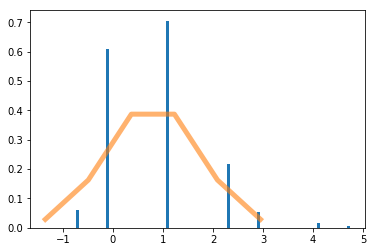

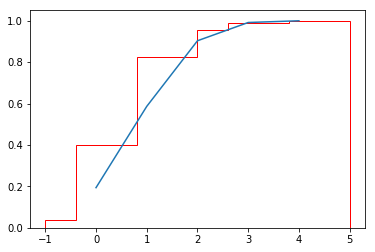

KstestResult(statistic=0.23771185888641777, pvalue=0.0)


In [402]:
'''
    Tentative to fit distribution to the delay, fails spectacularly with prognose data. 
    Problem is that some line only have prognose data status. Cannot estimate them with this 
'''

data = filtered_df[filtered_df.LINIEN_ID == "85:3849:007"].AN_DELAY.dropna().values

dist = st.norm

args = dist.fit(data)

print(args)

plt.hist(data, density=True, rwidth=0.1)
x = np.linspace(dist.ppf(0.01, *args), dist.ppf(0.99, *args), 6)
plt.plot(x, dist.pdf(x, *args), lw=5, alpha=0.6, label='expon pdf')

plt.show()

x = range(0, int(np.max(data)))
plt.hist(data, cumulative=True, normed=True, histtype="step", color="red")
plt.plot(x, dist.cdf(x, *args))
plt.show()

print(st.kstest(data, dist.cdf, args=args))

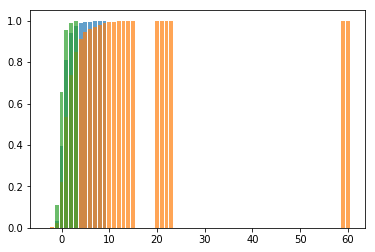

In [14]:
d1 = compute_cdf_data(filtered_df[(filtered_df.LINIEN_ID == "85:3849:007") & (filtered_df.DAY_OF_WEEK == 1)].AN_DELAY.dropna().values)
d2 = compute_cdf_data(filtered_df[(filtered_df.LINIEN_ID == "85:849:033") & (filtered_df.DAY_OF_WEEK == 1)].AN_DELAY.dropna().values)
d3 = compute_cdf_data(filtered_df[(filtered_df.LINIEN_ID == "85:849:917") & (filtered_df.DAY_OF_WEEK == 1)].AN_DELAY.dropna().values)

plt.bar(d1.keys(), d1.values(), alpha = 0.7)
plt.bar(d2.keys(), d2.values(), alpha = 0.7)
plt.bar(d3.keys(), d3.values(), alpha = 0.7)

plt.show()

In [7]:
useful_col = ["AN_DELAY", "HALTESTELLEN_NAME", "LINIEN_ID", "PRODUKT_ID", "BETREIBER_ABK", "TIME_BUCKET", "DAY_OF_WEEK"] 
groupby_col = ["TIME_BUCKET", "PRODUKT_ID", "DAY_OF_WEEK"]

grouped_df = filtered_df[useful_col].groupby(groupby_col).apply(lambda group: pd.Series(compute_cdf_data(group.AN_DELAY.dropna().values)))

In [58]:
def compute_mse_with_model(row):
    if pd.isnull(row.AN_DELAY):
        return row.AN_DELAY
    else:
        try: 
            return (row.AN_DELAY - grouped_df[row.TIME_BUCKET, row.PRODUKT_ID, row.DAY_OF_WEEK, 0])**2
        except KeyError:
            return 0

filtered_df["ERROR"] = filtered_df.apply(compute_mse_with_model, axis=1)

In [59]:
filtered_df.ERROR.mean()

8.335069620006157

In [61]:
filtered_df.ERROR.var()

158472.9635984206

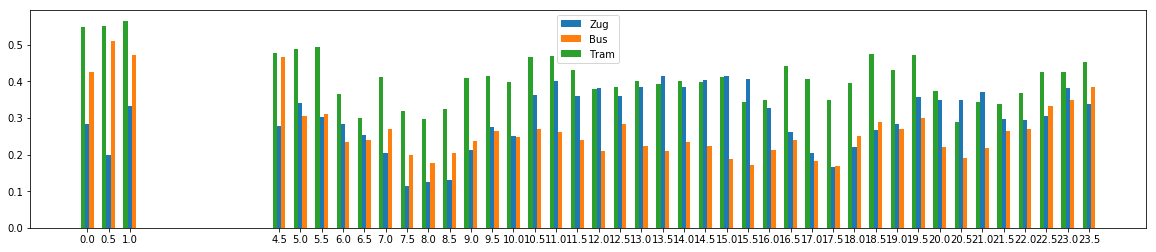

In [18]:
plt.figure(figsize=(20,4))
plt.bar(grouped_df.loc[:, "Zug", 0, 0].keys()/2., grouped_df.loc[:, "Zug", 0, 0], width=0.1)
plt.bar(grouped_df.loc[:, "Bus", 0, 0].keys()/2.+0.1, grouped_df.loc[:, "Bus", 0, 0], width=0.1)
plt.bar(grouped_df.loc[:, "Tram", 0, 0].keys()/2.-0.1, grouped_df.loc[:, "Tram", 0, 0], width=0.1)
plt.xticks(list(grouped_df.loc[:, "Zug", 0, 0].keys()/2.))

plt.legend(["Zug", "Bus", "Tram"])

plt.show()

In [403]:
filtered_df.columns

Index(['BETRIEBSTAG', 'FAHRT_BEZEICHNER', 'BETREIBER_ID', 'BETREIBER_ABK',
       'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_ID', 'LINIEN_TEXT', 'UMLAUF_ID',
       'VERKEHRSMITTEL_TEXT', 'ZUSATZFAHRT_TF', 'FAELLT_AUS_TF', 'BPUIC',
       'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'AN_PROGNOSE',
       'AN_PROGNOSE_STATUS', 'ABFAHRTSZEIT', 'AB_PROGNOSE',
       'AB_PROGNOSE_STATUS', 'DURCHFAHRT_TF', 'AN_PROGNOSE_TS',
       'ANKUNFTSZEIT_TS', 'AB_PROGNOSE_TS', 'ABFAHRTSZEIT_TS', 'TIME_BUCKET',
       'AN_DELAY', 'AB_DELAY'],
      dtype='object')

In [77]:
t = datetime.datetime.strptime(month_df.head(1).BETRIEBSTAG.values[0], "%d.%m.%Y")